In [55]:
import pandas as pd
import numpy as np
import torch
from torch import nn, sigmoid
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [56]:
lookback_window = 5

In [ ]:
df = pd.read_csv('../datasets/processed/final_binned_sum_2_task_usage.csv')

df.head()

,time_bins,mean_CPU_usage_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache_memory_usage,total_page_cache_memory_usage,mean_disk_I/O_time,mean_local_disk_space_used,cycles_per_instruction,memory_accesses_per_instruction,sampled_CPU_usage,maximum_memory_usage,maximum_CPU_usage,maximum_disk_IO_time
0,1970-01-01 00:10:00,934.529654,1122.081556,1410.075742,137.780170,350.844039,86.576681,5.747562,232414.073578,760.927511,540.826122,0.752,1.861,1.070
1,1970-01-01 00:12:00,953.734497,1094.832993,1380.893418,137.186724,342.614090,90.112028,5.714715,233349.010286,763.722785,560.613661,0.752,1.861,1.070
2,1970-01-01 00:14:00,1069.803710,1137.664539,1430.936623,138.977231,343.964416,107.931067,5.800870,246048.623559,807.370802,673.262978,0.752,1.861,1.070
3,1970-01-01 00:16:00,949.991326,1099.295547,1386.312936,137.164647,341.334571,90.891698,5.745408,232222.657193,761.606960,548.807038,0.752,1.656,1.041
4,1970-01-01 00:18:00,962.463198,1106.237590,1395.191419,137.889897,342.393872,92.711914,5.766440,229743.424184,755.449583,563.318817,0.752,1.656,1.041


# **EDA**

In [58]:
num_df = df.select_dtypes(include="number") 
Q3 = num_df.quantile(0.75)
Q1 = num_df.quantile(0.25)

upper_bound = Q3 + 3*(Q3 - Q1) / 2
lower_bound = Q1 - 3*(Q3 - Q1) / 2

outliers = (num_df < lower_bound) | (num_df > upper_bound)

print(f"Outliers Percentage: {len(outliers.sum()) / len(df)}")

Outliers Percentage: 0.0006226053639846744


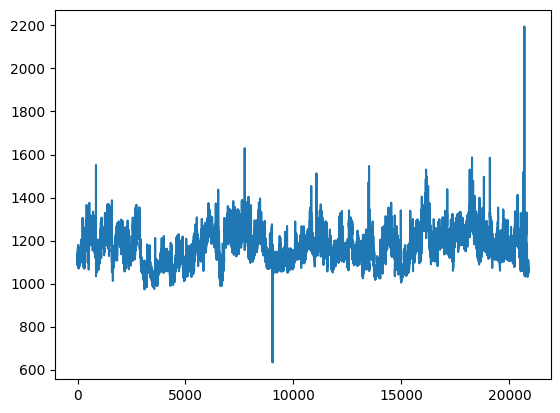

In [59]:
df['canonical_memory_usage'].plot.line()

plt.show()

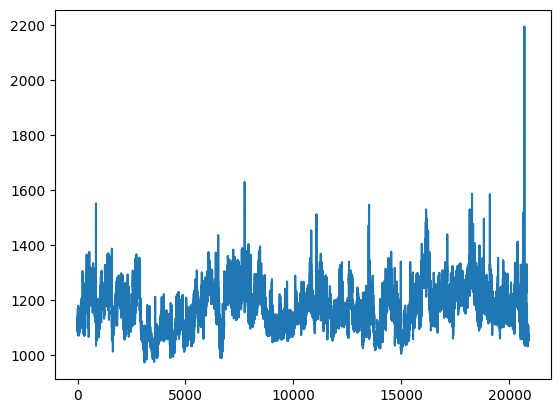

In [60]:
# Step 2: Replace Flagged canonical_memory_usages with NaN
df.loc[df['canonical_memory_usage'] < 900, 'canonical_memory_usage'] = np.nan

# Step 3: Interpolate the NaN canonical_memory_usages
df['canonical_memory_usage'] = df['canonical_memory_usage'].interpolate(method='cubicspline')

df['canonical_memory_usage'].plot.line()

plt.show()

In [61]:
# Calculate the sizes for each split
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

# **Preprocessing**

In [62]:
cpu_max = df['mean_CPU_usage_rate'][:train_size].max()
memory_max = df['canonical_memory_usage'][:train_size].max()

print(cpu_max, memory_max)

2763.6376649446083 1629.8015765898892


In [63]:
df['mean_CPU_usage_rate'] = df['mean_CPU_usage_rate'] / cpu_max

df['mean_CPU_usage_rate'] = df['mean_CPU_usage_rate'].clip(0, 1)

In [64]:
df[['transformed_mean_CPU_usage_rate']] = np.log1p(df[['mean_CPU_usage_rate']])

In [65]:
df['transformed_mean_CPU_usage_rate'] = savgol_filter(df['transformed_mean_CPU_usage_rate'], window_length=5, polyorder=3)

### Creating Lag features for the time series data.

In [66]:
for i in range(1, lookback_window + 1):
    df[f'mean_CPU_usage_rate_-{i*2}min'] = df['mean_CPU_usage_rate'].shift(i)

df['rolling_mean_CPU_usage'] = df['mean_CPU_usage_rate'].rolling(center=False, window=2).mean()
df['rolling_std_CPU_usage'] = df['mean_CPU_usage_rate'].rolling(center=False, window=2).std()

df = df.fillna(0)
df.head()

,time_bins,mean_CPU_usage_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache_memory_usage,total_page_cache_memory_usage,mean_disk_I/O_time,mean_local_disk_space_used,cycles_per_instruction,memory_accesses_per_instruction,...,maximum_CPU_usage,maximum_disk_IO_time,transformed_mean_CPU_usage_rate,mean_CPU_usage_rate_-2min,mean_CPU_usage_rate_-4min,mean_CPU_usage_rate_-6min,mean_CPU_usage_rate_-8min,mean_CPU_usage_rate_-10min,rolling_mean_CPU_usage,rolling_std_CPU_usage
0,1970-01-01 00:10:00,0.338152,1122.081556,1410.075742,137.780170,350.844039,86.576681,5.747562,232414.073578,760.927511,...,1.861,1.070,0.288637,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,1970-01-01 00:12:00,0.345101,1094.832993,1380.893418,137.186724,342.614090,90.112028,5.714715,233349.010286,763.722785,...,1.861,1.070,0.307079,0.338152,0.000000,0.000000,0.000000,0.0,0.341627,0.004914
2,1970-01-01 00:14:00,0.387100,1137.664539,1430.936623,138.977231,343.964416,107.931067,5.800870,246048.623559,807.370802,...,1.861,1.070,0.311300,0.345101,0.338152,0.000000,0.000000,0.0,0.366100,0.029698
3,1970-01-01 00:16:00,0.343747,1099.295547,1386.312936,137.164647,341.334571,90.891698,5.745408,232222.657193,761.606960,...,1.656,1.041,0.306831,0.387100,0.345101,0.338152,0.000000,0.0,0.365423,0.030655
4,1970-01-01 00:18:00,0.348260,1106.237590,1395.191419,137.889897,342.393872,92.711914,5.766440,229743.424184,755.449583,...,1.656,1.041,0.297069,0.343747,0.387100,0.345101,0.338152,0.0,0.346003,0.003191


In [67]:
lag_features = []

for i in range(1, lookback_window + 1):
    lag_features.append(f'mean_CPU_usage_rate_-{i*2}min')

In [68]:
features = [
    'transformed_mean_CPU_usage_rate',
    'rolling_std_CPU_usage',
    'rolling_mean_CPU_usage',
    *lag_features,
]

target = [
    'mean_CPU_usage_rate',
]

df = df[target + features]

In [69]:
df.head(8)

,mean_CPU_usage_rate,transformed_mean_CPU_usage_rate,rolling_std_CPU_usage,rolling_mean_CPU_usage,mean_CPU_usage_rate_-2min,mean_CPU_usage_rate_-4min,mean_CPU_usage_rate_-6min,mean_CPU_usage_rate_-8min,mean_CPU_usage_rate_-10min
0,0.338152,0.288637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.345101,0.307079,0.004914,0.341627,0.338152,0.000000,0.000000,0.000000,0.000000
2,0.387100,0.311300,0.029698,0.366100,0.345101,0.338152,0.000000,0.000000,0.000000
3,0.343747,0.306831,0.030655,0.365423,0.387100,0.345101,0.338152,0.000000,0.000000
4,0.348260,0.297069,0.003191,0.346003,0.343747,0.387100,0.345101,0.338152,0.000000
5,0.352888,0.292100,0.003273,0.350574,0.348260,0.343747,0.387100,0.345101,0.338152
6,0.337858,0.314852,0.010628,0.345373,0.352888,0.348260,0.343747,0.387100,0.345101
7,0.446210,0.346329,0.076617,0.392034,0.337858,0.352888,0.348260,0.343747,0.387100


In [70]:
# Split the dataset
train_set = df[:train_size]
val_set = df[train_size:train_size + val_size]
test_set = df[train_size + val_size:]

In [71]:
train_set = np.array(train_set)
val_set = np.array(val_set)
test_set = np.array(test_set)

# Print the shapes to verify the splits
print(f"Train set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")
print(f"Test set shape: {test_set.shape}")

Train set shape: (16704, 9)
Validation set shape: (2088, 9)
Test set shape: (2088, 9)


In [72]:
def create_sequence(data: torch.Tensor, seq_length: int, output_dim: int):
    num_samples = data.shape[0] - seq_length
    
    X = torch.stack([data[i : i + seq_length, output_dim:] for i in range(num_samples)])
    Y = data[seq_length:, 0:output_dim]
    
    return X, Y

In [73]:
seq_length = 10 

X, Y = create_sequence(torch.tensor(train_set).to(torch.float32), seq_length, len(target))

X.shape, Y.shape

(torch.Size([16694, 10, 8]), torch.Size([16694, 1]))

In [74]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(X, Y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)

In [75]:
X_val, Y_val = create_sequence(torch.tensor(val_set).to(torch.float32), seq_length, len(target))
val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

In [76]:
X_test, Y_test = create_sequence(torch.tensor(test_set).to(torch.float32), seq_length, len(target))

In [77]:
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

# **Modeling**

In [78]:
class Predictor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size=1):
        super().__init__()
        
        self.memory_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.3,
            num_layers=2,
            bidirectional=True,            
        )
        
        # Fully connected layers
        # The LSTM output size is doubled due to bidirectionality
        self.fc = nn.Sequential(  
            nn.Dropout(),
            nn.Linear(in_features=hidden_size*2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=output_size), 
        )
        
    def forward(self, x):
        # Pass input through the LSTM
        out, _ = self.memory_layer(x) # out shape: (batch_size, seq_len, hidden_size * 2)
        
        output = out[:, -1, :]  
        
        # Apply fully connected layers with ReLU activation
        output = self.fc(output)
        
        return sigmoid(output)

In [79]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [80]:
input_size = len(features)
hidden_layer_size = 128
output_size = len(target)

model = Predictor(input_size, hidden_layer_size, output_size)
loss_fn = RMSLELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

In [81]:
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Average loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for X_val, y_val in val_dataloader:
            y_pred_val = model(X_val)
            loss_val = loss_fn(y_pred_val, y_val)
            epoch_val_loss += loss_val.item()
    
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    torch.save(model.state_dict(), "../models/best_model.pt")
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        # print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}")
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

print("Training complete.")

Epoch [10/100], Train Loss: 0.020339, Val Loss: 0.029354
Epoch [20/100], Train Loss: 0.016664, Val Loss: 0.023762
Epoch [30/100], Train Loss: 0.015434, Val Loss: 0.021781
Epoch [40/100], Train Loss: 0.014408, Val Loss: 0.021034
Epoch [50/100], Train Loss: 0.012932, Val Loss: 0.017673
Epoch [60/100], Train Loss: 0.010859, Val Loss: 0.014576
Epoch [70/100], Train Loss: 0.007773, Val Loss: 0.007074
Epoch [80/100], Train Loss: 0.006905, Val Loss: 0.005879
Epoch [90/100], Train Loss: 0.006359, Val Loss: 0.005339
Epoch [100/100], Train Loss: 0.006185, Val Loss: 0.005085
Training complete.


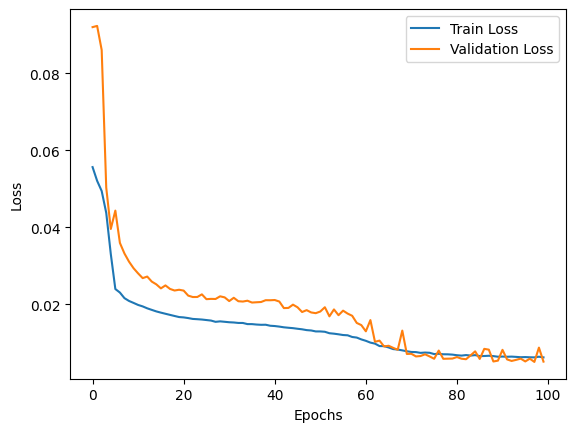

In [82]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = Predictor(input_size, hidden_layer_size, output_size, kernel_size=2)
model.load_state_dict(torch.load("../models/best_model.pt"))
model.eval()

Predictor(
  (memory_layer): LSTM(8, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


--- Variable mean_CPU_usage_rate ---
RMSE: 0.00881017113754161
MAE: 0.005890682339668274
MAPE: 0.01020656619220972
R2 Score: 0.9928348660469055


<Figure size 1200x600 with 0 Axes>

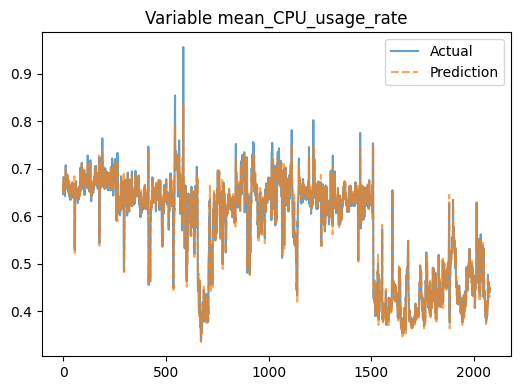

In [86]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_log_error
plt.figure(figsize=(12,6))

all_truth = []
all_pred = []

with torch.inference_mode():
    model.eval()
    for X_batch_test, y_batch_test in val_dataloader: 
        test_pred = model(X_batch_test)

        all_pred.extend(test_pred.numpy())
        all_truth.extend(y_batch_test.numpy())
        
all_truth = np.array(all_truth)
all_pred = np.array(all_pred)

for i in range(all_truth.shape[1]):
    print(f"\n--- Variable {target[i]} ---")
    print(f"RMSE: {np.sqrt(mean_squared_error(all_truth[:, i], all_pred[:, i]))}")
    print(f"MAE: {mean_absolute_error(all_truth[:, i], all_pred[:, i])}")
    print(f"MAPE: {mean_absolute_percentage_error(all_truth[:, i], all_pred[:, i])}")
    print(f"R2 Score: {r2_score(all_truth[:, i], all_pred[:, i])}")

# Plot each variable separately
plt.figure(figsize=(15, 4))

for i in range(all_truth.shape[1]):
    plt.subplot(1, 3, i+1)
    plt.plot(all_truth[:, i], label="Actual", alpha=0.7)
    plt.plot(all_pred[:, i], label="Prediction", linestyle="--", alpha=0.7)
    plt.title(f"Variable {target[i]}")
    plt.legend()

plt.tight_layout()
plt.show()


--- Variable mean_CPU_usage_rate ---
RMSE: 0.00830573221825697
MAE: 0.005034206435084343
MAPE: 0.010240728966891766
R2 Score: 0.9952293634414673


<Figure size 1200x600 with 0 Axes>

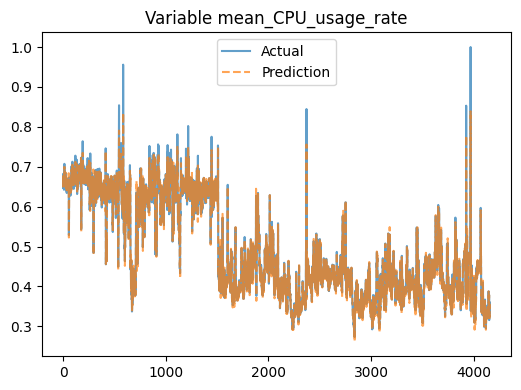

In [87]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_log_error
plt.figure(figsize=(12,6))

all_truth = []
all_pred = []

with torch.inference_mode():
    model.eval()
    for X_batch_test, y_batch_test in val_dataloader: 
        test_pred = model(X_batch_test)

        all_pred.extend(test_pred.numpy())
        all_truth.extend(y_batch_test.numpy())
    for X_batch_test, y_batch_test in test_dataloader: 
        test_pred = model(X_batch_test)

        all_pred.extend(test_pred.numpy())
        all_truth.extend(y_batch_test.numpy())
        
all_truth = np.array(all_truth)
all_pred = np.array(all_pred)

for i in range(all_truth.shape[1]):
    print(f"\n--- Variable {target[i]} ---")
    print(f"RMSE: {np.sqrt(mean_squared_error(all_truth[:, i], all_pred[:, i]))}")
    print(f"MAE: {mean_absolute_error(all_truth[:, i], all_pred[:, i])}")
    print(f"MAPE: {mean_absolute_percentage_error(all_truth[:, i], all_pred[:, i])}")
    print(f"R2 Score: {r2_score(all_truth[:, i], all_pred[:, i])}")

# Plot each variable separately
plt.figure(figsize=(15, 4))

for i in range(all_truth.shape[1]):
    plt.subplot(1, 3, i+1)
    plt.plot(all_truth[:, i], label="Actual", alpha=0.7)
    plt.plot(all_pred[:, i], label="Prediction", linestyle="--", alpha=0.7)
    plt.title(f"Variable {target[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

In [88]:
val_set[-15:-1, :2]

array([[0.41083729, 0.33487161],
       [0.39142536, 0.33656844],
       [0.40263326, 0.33821705],
       [0.41874004, 0.34337698],
       [0.41576044, 0.36283925],
       [0.47654463, 0.36813657],
       [0.42836606, 0.3752858 ],
       [0.46290236, 0.36975292],
       [0.45477364, 0.37924633],
       [0.45901863, 0.37707282],
       [0.45619342, 0.37278634],
       [0.43873178, 0.3689085 ],
       [0.45028401, 0.36855806],
       [0.44768001, 0.36582734]])